# Homework 4

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import sqlite3 as sql
import re

## Joining Data

### Data

In [98]:
cleaned_cellphones_df = pd.read_csv("cleaned_cellphones_df.csv")
population_df = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
population_df = population_df.drop(columns=["Unnamed: 0"], errors='ignore')
country_df = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")

### Task

We first need to deal with missing values, we start by examining if there are any rows (countries) in our dataframe with only missing values. 

In [99]:
subset = population_df.loc[:, '1960':'2020']
all_nan_rows = subset.isna().all(axis=1) # returns True for all the rows with only NaN
population_df[all_nan_rows]

,iso-3,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
110,INX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Because this row only has missing values we remove it from our dataframe.

In [100]:
cleaned_population_df = population_df.drop(index=population_df[all_nan_rows].index)

Next we examine if there are any other rows with missing values. 

In [101]:
rows_with_nan = cleaned_population_df[cleaned_population_df.isna().any(axis=1)]
rows_with_nan

,iso-3,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
196,PSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3882986.0,3979998.0,4076708.0,4173398.0,4270092.0,4367088.0,4454805.0,4569087.0,4685306.0,4803269.0


We see that only the row with index `196` has any missing values. To deal with these missing values we use linear regression to predict previous values based on future ones. 

In [102]:
# Create a linear regression model
model = LinearRegression()

# Iterate while there are still NaN values in the row
while cleaned_population_df.loc[196].isna().sum() > 0:
    # Identify NaN values in the row
    nan_indices = cleaned_population_df.loc[196].index[cleaned_population_df.loc[196].isna()]

    # Loop over each NaN value from right to left
    for nan_idx in nan_indices[::-1]:
        # Get the integer position of the column in the dataframe
        col_idx = cleaned_population_df.columns.get_loc(nan_idx)  # Get the integer index of the column
        
        # Select the values to the right of the NaN index using integer slicing
        right_values = cleaned_population_df.loc[196].iloc[col_idx+1:]  # all values after the NaN index
        
        # Check if there are enough values to perform regression (no NaNs in the right values)
        if right_values.isna().sum() == 0 and len(right_values) > 1:
            # Reshape the data to fit the model
            x = np.array(range(len(right_values))).reshape(-1, 1)  # index positions as features
            y = right_values.values  # the actual values to predict
            
            # Train the model on these data points
            model.fit(x, y)
            
            # Predict the value for the current NaN position
            predicted_value = model.predict(np.array([[0]]))  # predicting the first value (just before the known ones)
            
            # Replace the NaN value with the predicted value directly in the dataframe
            cleaned_population_df.loc[196, nan_idx] = round(max(predicted_value[0], 18434), 0)

On the last line of code we used `max()` to ensure that we didn't get any negative values and we replaced the `NaN` with 18434 if this was the case since that was the least positive value we got from the linear regression. If we print the first six values from the row with index `196` we see that the last five values all are 18434 which means that the last four were all negative. The drawback with this is that it's not reasonable that a countries' population did not change at all in five years, but that is a compromise we have to take. We can also notice the increase in population from 1964 to 1965 which is an unlikely increase, but that is also a compromise we have to take with this approach. 

In [103]:
cleaned_population_df.loc[196].head(7) # we use head(7) instead of head(6) since head() also includes the cell from the column "iso-3"

iso-3        PSE
1960     18434.0
1961     18434.0
1962     18434.0
1963     18434.0
1964     18434.0
1965     96629.0
Name: 196, dtype: object

Now that we've finally dealt with missing values we can start with combining the cellphone data with the population data. We create a new dataframe `combined_df` with the columns `iso-3`, `year`, `n_cellphones` and `population`.

In [111]:
# Transforms wide-format data (years as columns) into long-format
cleaned_cellphones_pivot_df = cleaned_cellphones_df.melt(id_vars="iso-3", var_name="year", value_name="n_cellphones")
cleaned_population_pivot_df = cleaned_population_df.melt(id_vars="iso-3", var_name="year", value_name="population")

# Merge the two datasets
combined_df = pd.merge(
    cleaned_cellphones_pivot_df, cleaned_population_pivot_df, on=["iso-3", "year"], how="outer"
)

# Fill missing values (this is necessary since the cellphones data is missing the columns with the years 1961-1964 and 2020)
combined_df["n_cellphones"] = combined_df["n_cellphones"].fillna(0)

# Sort the data for better readability
combined_df = combined_df.sort_values(by=["iso-3", "year"]).reset_index(drop=True)

Now that we've combined the two dataframes we create a new dataframe `filtered_df` to present the table given in the task.

In [112]:
countries_to_include = ["ABW", "AFG", "AGO", "ALB", "AND"]

# Filter the dataframe
filtered_df = combined_df[
    (combined_df["iso-3"].isin(countries_to_include)) &
    (combined_df["year"] == "1960")
]

filtered_df

,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
122,AFG,1960,0.0,8622466.0
244,AGO,1960,0.0,5357195.0
305,ALB,1960,0.0,1608800.0
366,AND,1960,0.0,9443.0


Now we merge the dataframe `country_df` with our already merged dataframe `combined_df` so that we use the countries' real names instead of the iso-3 format.

In [154]:
# Merge combined_df with country_df on "iso-3" and "alpha-3"
final_df = pd.merge(
    combined_df,
    country_df,
    left_on="iso-3",
    right_on="alpha-3",
    how="inner"
)

# Drop the "iso-3" and "alpha-3" columns, keeping "name" as the country identifier
final_df = final_df.drop(columns=["iso-3", "alpha-3"])

# Only include the necessary columns
final_df = final_df[["name", "year", "n_cellphones", "population"]]

Next up, we calculate the number of phones per capita and present a table which shows us the top five countries with the highest number of phones per capita sorted for 2019. We also include those countries data for the years 2015-2018 since the table in the task includes those. Notice that we include the years 2010-2019 in the second line of code. This is because we will need those years for the task after this one.

In [191]:
# Add cellphones_per_capita
final_df["cellphones_per_capita"] = final_df["n_cellphones"] / final_df["population"]

# Filter for years 2010 to 2019 (useful for a later task)
final_df = final_df[final_df["year"].isin(["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])]

# Sort by cellphones_per_capita for 2019 and get top countries
filtered_2019 = final_df[final_df["year"] == "2019"]
top_countries = filtered_2019.nlargest(5, "cellphones_per_capita")["name"]

# Filter the main dataset for these top countries
top_df = final_df[final_df["name"].isin(top_countries)]

# Pivot the table to desired format
pivot_table = top_df.pivot(index="year", columns="name", values="cellphones_per_capita")
pivot_table = pivot_table.sort_values(by="2019", axis=1, ascending=False)

# Remove the "name" label
pivot_table.columns.name = None

# Only display the years 2015-2019
pivot_table.loc["2015":"2019"]

,Macao,Hong Kong,United Arab Emirates,Seychelles,Antigua and Barbuda
year,,,,,
2015,3.088231,2.290401,2.007424,1.584260,1.956838
2016,3.143510,2.398931,2.212521,1.605459,1.987545
2017,3.210102,2.488773,2.183431,1.742433,2.019337
2018,3.348741,2.670209,2.199084,1.849900,1.964508
2019,3.114078,2.863650,2.127739,1.987196,1.968507


Now we create a plot that illustrates the growth rate of cellphones per capita for the countries in the table above over the last 10 years, as well as print the country with the highest growth rate. 

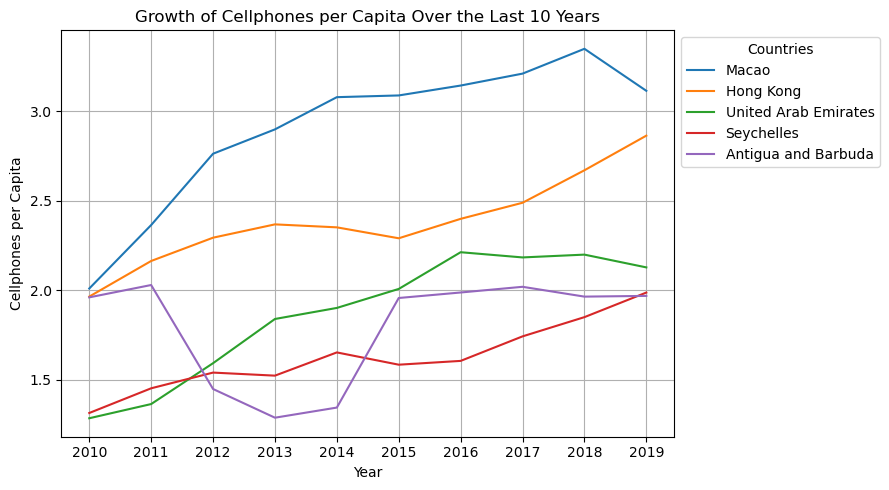

United Arab Emirates : 0.656


In [190]:
# Calculate growth rate for each country over the period 2010-2019
growth_rates = {}
for country in pivot_table.columns:
    start_value = pivot_table[country].iloc[0]
    end_value = pivot_table[country].iloc[-1]
    growth_rate = (end_value - start_value) / start_value
    growth_rates[country] = growth_rate

# Plot growth rates over the years
plt.figure(figsize=(9, 5))

for country in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[country], label=country)

plt.title("Growth of Cellphones per Capita Over the Last 10 Years")
plt.xlabel("Year")
plt.ylabel("Cellphones per Capita")
plt.legend(title="Countries", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()

plt.show()

# Display the country with the highest growth rate and its growth rate
print(max(growth_rates), ":", round(growth_rates[max(growth_rates)],3))


## SQL

### Data

In [230]:
connection = sql.connect("./user_actions.db")
cursor = connection.cursor()

### Tasks

To retrieve the usernames of all users who have performed the action `signup`, we use a query where we select the user's username from the database `user_actions` if the same user's action is `signup`.

In [231]:
query = """
SELECT username 
FROM user_actions 
WHERE action = 'signup'
"""

cursor.execute(query)
pd.read_sql_query(query, connection)

,username
0,user34
1,user28
2,user1
3,user24
4,user15
5,user20
6,user18
7,user25
8,user3
9,user9


To find the total number of log entries for each user and then display the user_id, username, and the count of log entries, we use the following query and then the function `read_sql_query()` from the pandas library to display this information as a table.

In [232]:
query = """
SELECT user_id, username, COUNT(*) AS log_count
FROM user_actions
GROUP BY user_id, username
"""

pd.read_sql_query(query, connection)

,user_id,username,log_count
0,1,user1,104
1,2,user2,149
2,3,user3,108
3,4,user4,436
4,5,user5,192
5,6,user6,457
6,7,user7,362
7,8,user8,329
8,9,user9,118
9,10,user10,170


To identify users who have both logged in and signed up on the same day and then display the user_id and username, we use the following query where:
- `DISTICT` ensures that each user only appears once in the table
- `ua1` and `ua2` are aliases that are used to distinguish between the two user actions `signup` and `login`


In [233]:
query = """
SELECT DISTINCT ua1.user_id, ua2.username
FROM user_actions ua1
JOIN user_actions ua2
ON ua1.user_id = ua2.user_id
WHERE ua1.action = 'signup' 
  AND ua2.action = 'login'
  AND DATE(ua1.timestamp) = DATE(ua2.timestamp);
"""

pd.read_sql_query(query, connection)

,user_id,username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


## Regex

### Data

Here we append each line/comment to a list `comments`. 

In [286]:
comments = []
with open("./comments.txt", "r") as file:
    for line in file:
        comments.append(line.strip())

### Tasks

We write a function `extract_hashtags()` that extracts all the words starting with a `#` from `comment`.

In [287]:
def extract_hashtags(comment):
    return re.findall(r"#\w+", comment)

If we apply this function to, for example comment 9 in the textfile, we get the following:

In [288]:
extract_hashtags(comments[8]) # we use the position 9-1=8 since indexing in python starts at 0

['#data', '#analytics']

Next we create a regular expression to find comments that mention both "#programming" and "#python". For this we iterate through each comment and then use `re.search()` to check if each comment matches our specified pattern, if it does then we append it to the list `matching_comments`. If we then print each comment in this list we see that comment 2 is not in it.

In [292]:
pattern = r"(?=.*#programming)(?=.*#python)"

matching_comments = []
for comment in comments:
    if re.search(pattern, comment):
        matching_comments.append(comment.strip())

for comment in matching_comments:
    print(comment)

6. "I learned a lot. #programming #python #tips"
15. "Well explained. #programming #python #tips"
21. "Love the content! #programming #python #tips"
30. "Inspired by the tips. #programming #python #tips"
